In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import sys
import os
import pathlib
path_to_package = os.path.join(pathlib.Path.home(), "work/ongoing/trimesh")
sys.path[0] = path_to_package
import trimesh
import numpy as np
import pandas as pd

import glob

sys.path.append("../code")

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
from manuscript import organs

In [14]:
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

### Plot 2D trajectories from pancreas to liver
We first load the mesh for the source organ, the liver in this case.

In [15]:
_organ = "pancreas"
source_organ = trimesh.load_mesh(f"../data/SelectedBodyParts3D/organ/{_organ}/{_organ}.obj")

And some trajectories (only a subset of length < 10K included in the repo to avoid committing very large files)

In [16]:
df = pd.read_pickle("../output/data/tracers/pancreas_tracers_selected_for_plot.p")

Next, we load the contact points that identify nodes of the directed network with organs

In [17]:
contact_points_dict = {
    (fpath.split("/")[-1].split("_solved_")[0]): set(pd.read_csv(fpath, header=None).values.T[0])
    for fpath in glob.glob("../output/data/organs_contact_points/*_solved_main_network_threshold10.0_contacts.txt")
}

And determine the final organ of each trajectory, if any. We set a generic "skin" value otherwise

In [18]:
_x = {}
for organ, nodes in contact_points_dict.items():
    for node in nodes:
        _x[node] = organ

In [19]:
df["target_organ"] = df.final_node.apply(
    lambda x: _x[x] if x in _x else "skin"
                   )

There is also a mesh file for the skin:

In [20]:
skin = trimesh.load_mesh("../data/SelectedBodyParts3D/skin/FJ2810.obj")

Now we load the target organ, liver in this case

In [21]:
_target_organ = "liver"
target_organ = trimesh.load_mesh(f"../data/SelectedBodyParts3D/organ/{_target_organ}/{_target_organ}.obj")

and select trajectories that finish at some organ

In [22]:
trajs_df = df.loc[df.target_organ != "skin"]

/Users/fontclos/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


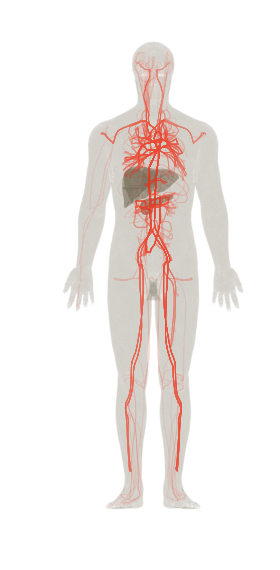

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(4, 10), tight_layout=True)
skin_polycollection = mpl.collections.PolyCollection(
    verts=skin.triangles[:, :, [0, 2]],
    facecolors="#786e5a",
    alpha=0.1
)

source_polycollection = mpl.collections.PolyCollection(
    verts=source_organ.triangles[:, :, [0, 2]],
    facecolors="#786e5a",
    alpha=0.5
)

target_polycollection = mpl.collections.PolyCollection(
    verts=target_organ.triangles[:, :, [0, 2]],
    facecolors="#786e5a",
    alpha=0.5
)
ax.set_aspect(1)
ax.add_collection(skin_polycollection)
ax.add_collection(source_polycollection)
ax.add_collection(target_polycollection)
ax.set_xlim(-400, 400)
ax.set_ylim(-200, 1750)

for _pos in trajs_df._positions.values[:30]:
    _x, _y = np.array(_pos)[:, [0, 2]].T
    ax.plot(_x, _y, alpha=0.1, lw=1, color="#f22d13")

ax.set_axis_off()
fig.savefig("../figures/tracers-2d-plot/tracer-2d-pancreas-liver.png", dpi=600)